# Exploring the Global Drifters Database dataset

The data is extracted from the public FTP ftp://ftp.aoml.noaa.gov/pub/phod/buoydata/

In [1]:
import os
import urllib.request
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.cm as cm
import cartopy.crs as ccrs
%matplotlib inline

In [2]:
# this folder has to exist before and you have to download
# from the public FTP before
folder = os.path.expanduser('~/Documents/data/gdp/src/')

In [3]:
files = [folder + 'buoydata_1_5000.dat', folder + 'buoydata_5001_10000.dat',
         folder + 'buoydata_10001_15000.dat', folder + 'buoydata_15001_mar19.dat']

def parse_date(yy, mm, dd):
    # days have decimal for hours
    dd = float(dd)
    hour = (dd - int(dd)) * 24
    return datetime(int(yy), int(mm), int(dd), int(hour))

# add a datenum values
def datenum_matlab(t):
    return 366 + t.toordinal() + (3600. * t.hour + 60. * t.minute + t.second)/86400.

# buoydata header
# ID, Position Time(MM,DD.dd,YYYY), Lat, Lon, SST(Deg C),
# VE(CM/S), VN(CM/S), SPD(CM/S), VAR.LAT, VAR.LON, VAR.TEMP
col_names = ['id', 'month', 'day', 'year', 'lat', 'lon', 'temp',
            've', 'vn', 'spd', 'var_lat', 'var_lon', 'var_tmp']

# parse all the csv files (takes about 5min)
df = pd.concat([pd.read_csv(f, names=col_names, sep='\s+', header=None, na_values=999.999,
                parse_dates=False, dtype=np.float64) for f in files], keys=files)

# faster to do calculate the date after like this
df['date'] = np.vectorize(parse_date)(df['year'], df['month'], df['day'])
df['datenum'] = df['date'].apply(datenum_matlab)                                         
df.head()

id  month   day  \
/Users/pmiron/Documents/data/gdp/src/buoydata_1... 0  7702986.0    3.0  8.00   
                                                   1  7702986.0    3.0  8.25   
                                                   2  7702986.0    3.0  8.50   
                                                   3  7702986.0    3.0  8.75   
                                                   4  7702986.0    3.0  9.00   

                                                        year    lat      lon  \
/Users/pmiron/Documents/data/gdp/src/buoydata_1... 0  1988.0 -1.320  274.848   
                                                   1  1988.0 -1.242  274.772   
                                                   2  1988.0 -1.176  274.657   
                                                   3  1988.0 -1.131  274.548   
                                                   4  1988.0 -1.064  274.468   

                                                        temp      ve      vn  \
/Users/pmiron/Documents/data/gdp/src/buoydata_1... 0  25.473     NaN     NaN   
                                                   1  25.224 -49.214  36.778   
                                                   2  25.095 -57.514  28.439   
                                                   3  25.545 -48.625  28.747   
                                                   4  25.870 -50.787  34.399   

                                                         spd   var_lat  \
/Users/pmiron/Documents/data/gdp/src/buoydata_1... 0     NaN  0.000025   
                                                   1  61.438  0.000058   
                                                   2  64.161  0.000020   
                                                   3  56.487  0.000049   
                                                   4  61.340  0.000004   

                                                       var_lon   var_tmp  \
/Users/pmiron/Documents/data/gdp/src/buoydata_1... 0  0.000034  0.004518   
                                                   1  0.000087  0.007215   
                                                   2  0.000026  0.005613   
                                                   3  0.000072  0.005837   
                                                   4  0.000006  0.003111   

                                                                    date  \
/Users/pmiron/Documents/data/gdp/src/buoydata_1... 0 1988-03-08 00:00:00   
                                                   1 1988-03-08 06:00:00   
                                                   2 1988-03-08 12:00:00   
                                                   3 1988-03-08 18:00:00   
                                                   4 1988-03-09 00:00:00   

                                                        datenum  
/Users/pmiron/Documents/data/gdp/src/buoydata_1... 0  726170.00  
                                                   1  726170.25  
                                                   2  726170.50  
                                                   3  726170.75  
                                                   4  726171.00

In [4]:
print('%d datapoints for a total of %d drifters' % (df['id'].size, np.unique(df['id']).size))
print('(from %s to %s)' % (np.min(df['date']),np.max(df['date'])))

37579393 datapoints for a total of 23693 drifters
(from 1979-02-15 00:00:00 to 2019-04-04 00:00:00)


# drifl files contain additional drogued information

### Header
ID, WMO, expno, type buoy, ddate, dtime, dlat, dlon, edate, etime, Elat, elon, date, ltime, typedeath
- id, integer, dddddddd, AOML buoy identification number (PKey)
- wmo, integer, ddddd, World Meteorological Center buoy identification number
- expno, integer, dddddd, Experiment number
- typebuoy, varchar(8,0), aaaaaaaa, Buoy type (SVP=standard Surface
- ddate, date, yyyy/mm/dd, Deployment date
- dtime, char(5), hh:mm, Deployment time
- dlat, smallfloat, sdd.dd, Deployment latitude
- dlon, smallfloat, sddd.dd, Deployment longitude (-180, 180) (E => +, W => -) (Missing Value = 999.99)
- edate, date, yyyy/mm/dd, End date (not available=set to NULL on database and set to 0000/00/00 on display
- etime, char(5), hh:mm, End time (Missing Value=00:00)
- elat, smallfloat, sdd.dd, End latitude (-90, 90) (N => +, S => -)
- elon, smallfloat, sddd.dd, End longitude (-180, 180) (E => +, W => -) (Missing Value = 999.99)
- ldate, date, yyyy/mm/dd, Date drogue lost (not available=set to NULL on database and set to 0000/00/00 on display)
- ltime, char(5), hh:mm, Time drogue lost (not available=set to NULL on database and set to 00:00 on display)
- typedeath, smallint, dd, Type of death (0=buoy still alive, 1=buoy ran aground, 2=picked up by vessel, 3=stop transmitt

In [5]:
files = [folder + 'dirfl_1_5000.dat', folder + 'dirfl_5001_10000.dat',
         folder + 'dirfl_10001_15000.dat', folder + 'dirfl_15001_mar19.dat']

# buoydata header
# ID, Position Time(MM,DD.dd,YYYY), Lat, Lon, SST(Deg C),
# VE(CM/S), VN(CM/S), SPD(CM/S), VAR.LAT, VAR.LON, VAR.TEMP
col_names = ['id', 'wmo', 'expno', 'type', 
             'ddate', 'dtime', 'dlat', 'dlon',
             'edate', 'etime', 'elat', 'elon', 
             'ldate', 'ltime', 'typedeath']

na_col = [np.nan, np.nan, np.nan, np.nan,  
          '0000/00/00', None, -99.99, -999.99, 
          '0000/00/00', None, -99.99, -999.99,
          '0000/00/00', None, -99.99, -999.99,
          '0000/00/00', None, np.nan]

# if time is unknown it is set to 00:00 but I kept it that way so the datetime
# isn't transform to NaN but instead only date with a midnight time
df_aux = pd.concat([pd.read_csv(f, names=col_names, sep='\s+', header=None, na_values=na_col) for f in files], keys=files)

df_aux['ddate'] = pd.to_datetime(df_aux['ddate'] + " " + df_aux['dtime'])
df_aux['edate'] = pd.to_datetime(df_aux['edate'] + " " + df_aux['etime'])
df_aux['ldate'] = pd.to_datetime(df_aux['ldate'] + " " + df_aux['ltime'])
df_aux = df_aux.drop(columns=['dtime', 'etime', 'ltime'])
df_aux.head()

id    wmo  expno  \
/Users/pmiron/Documents/data/gdp/src/dirfl_1_50... 0  7702986  32520    129   
                                                   1  7702987  32518    129   
                                                   2  7704821  32512    129   
                                                   3  7704822  32519    129   
                                                   4  7704827  32560    129   

                                                     type               ddate  \
/Users/pmiron/Documents/data/gdp/src/dirfl_1_50... 0  SVP 1988-03-07 00:00:00   
                                                   1  SVP 1987-11-23 00:00:00   
                                                   2  SVP 1987-07-20 20:09:00   
                                                   3  SVP 1987-11-22 00:00:00   
                                                   4  SVP 1988-05-17 00:00:00   

                                                       dlat    dlon  \
/Users/pmiron/Documents/data/gdp/src/dirfl_1_50... 0  -1.37  274.89   
                                                   1  -1.77  274.92   
                                                   2 -15.02  276.94   
                                                   3 -12.50  281.86   
                                                   4 -12.70  281.30   

                                                                   edate  \
/Users/pmiron/Documents/data/gdp/src/dirfl_1_50... 0 1988-09-13 23:55:00   
                                                   1 1988-10-26 17:18:00   
                                                   2 1988-12-19 14:19:00   
                                                   3 1989-01-27 15:01:00   
                                                   4 1988-12-26 19:13:00   

                                                       elat    elon  \
/Users/pmiron/Documents/data/gdp/src/dirfl_1_50... 0   8.90  280.58   
                                                   1  -7.63  228.18   
                                                   2 -27.91  257.85   
                                                   3 -16.36  254.02   
                                                   4 -13.85  269.26   

                                                                   ldate  \
/Users/pmiron/Documents/data/gdp/src/dirfl_1_50... 0 1988-08-26 00:00:00   
                                                   1 1988-10-26 17:18:00   
                                                   2 1988-12-19 14:19:00   
                                                   3 1989-01-27 15:01:00   
                                                   4 1988-12-26 19:13:00   

                                                      typedeath  
/Users/pmiron/Documents/data/gdp/src/dirfl_1_50... 0          1  
                                                   1          3  
                                                   2          3  
                                                   3          3  
                                                   4          3

In [6]:
# merge the drogue information to the main dataframe since it has the same id
# we copy the loss datetime to a new column and then create
# a bool value if or not the drogue is present at this datapoint
df = pd.merge(df, df_aux[['id', 'ldate']], on='id')
df['drogue'] = df['date'] < df['ldate']

In [7]:
# remove lines with nan in the columns I'm interrested in
export_col = ['id', 'datenum', 'lon', 'lat']
df = df.dropna(axis=0, subset = export_col, how='any')

# set longitude between [-180, 180]
df.lon[df.lon>180] -= 360
df.head()

,id,month,day,year,lat,lon,temp,ve,vn,spd,var_lat,var_lon,var_tmp,date,datenum,ldate,drogue
0,7702986.0,3.0,8.00,1988.0,-1.320,-85.152,25.473,NaN,NaN,NaN,0.000025,0.000034,0.004518,1988-03-08 00:00:00,726170.00,1988-08-26,True
1,7702986.0,3.0,8.25,1988.0,-1.242,-85.228,25.224,-49.214,36.778,61.438,0.000058,0.000087,0.007215,1988-03-08 06:00:00,726170.25,1988-08-26,True
2,7702986.0,3.0,8.50,1988.0,-1.176,-85.343,25.095,-57.514,28.439,64.161,0.000020,0.000026,0.005613,1988-03-08 12:00:00,726170.50,1988-08-26,True
3,7702986.0,3.0,8.75,1988.0,-1.131,-85.452,25.545,-48.625,28.747,56.487,0.000049,0.000072,0.005837,1988-03-08 18:00:00,726170.75,1988-08-26,True
4,7702986.0,3.0,9.00,1988.0,-1.064,-85.532,25.870,-50.787,34.399,61.340,0.000004,0.000006,0.003111,1988-03-09 00:00:00,726171.00,1988-08-26,True


In [9]:
# export to csv file 
# save world dataset
save_all = False
save_ioce = False
save_ioce_time = False
save_sa = False
save_na = True
if save_all:
    df.to_csv(folder + 'gdp_world.csv', columns = export_col, index=False)
    df[df['drogue']].to_csv(folder + 'gdp_world_drogued.csv', columns = export_col, index=False)
    df[~df['drogue']].to_csv(folder + 'gdp_world_undrogued.csv', columns = export_col, index=False)

# export indian ocean
if save_ioce:
    zone = (df.lon>0) & (df.lon<160) & (df.lat>-60) & (df.lat<30)
    ioce = df.loc[zone]
    ioce.to_csv(folder + 'gdp-indian-ocean.csv', columns = export_col, index=False)
    ioce[ioce['drogue']].to_csv(folder + 'gdp-indian-ocean-drogued.csv', columns = export_col, index=False)
    ioce[~ioce['drogue']].to_csv(folder + 'gdp-indian-ocean-undrogued.csv', columns = export_col, index=False)

# export indian ocean between March 8, 2014 (MH370 disappearance) and today
if save_ioce_time:
    zone = (df.lon>0) & (df.lon<160) & (df.lat>-60) & (df.lat<30) & (df.date>'2014-03-08')
    ioce = df.loc[zone]
    ioce.to_csv(folder + 'gdp-indian-ocean-mh370.csv', columns = export_col, index=False)
    ioce[ioce['drogue']].to_csv(folder + 'gdp-indian-ocean-drogued-mh370.csv', columns = export_col, index=False)
    ioce[~ioce['drogue']].to_csv(folder + 'gdp-indian-ocean-undrogued-mh370.csv', columns = export_col, index=False)
    
# export south Atlantic 70S to 10S and 70W to 50E
if save_sa:
    zone = (df.lon>-71) & (df.lon<51) & (df.lat>-69) & (df.lat<-9)
    ioce = df.loc[zone]
    ioce.to_csv(folder + 'gdp-south-atlantic.csv', columns = export_col, index=False)
    ioce[ioce['drogue']].to_csv(folder + 'gdp-south-atlantic-drogued.csv', columns = export_col, index=False)
    ioce[~ioce['drogue']].to_csv(folder + 'gdp-south-atlantic-undrogued.csv', columns = export_col, index=False)

# export north Atlantic 10S to 90N and 100W to 35E
if save_na:
    zone = (df.lon>-100) & (df.lon<35) & (df.lat>-11) & (df.lat<90)
    ioce = df.loc[zone]
    ioce.to_csv(folder + 'gdp-north-atlantic.csv', columns = export_col, index=False)
    ioce[ioce['drogue']].to_csv(folder + 'gdp-north-atlantic-drogued.csv', columns = export_col, index=False)
    ioce[~ioce['drogue']].to_csv(folder + 'gdp-north-atlantic-undrogued.csv', columns = export_col, index=False)

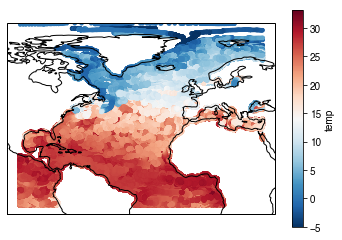

In [10]:
na_atlantic = (df.lon>-100) & (df.lon<35) & (df.lat>-11) & (df.lat<90)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
df.loc[na_atlantic].plot(kind='scatter', x='lon', y='lat', c='temp', cmap='RdBu_r', edgecolor='none', ax=ax)

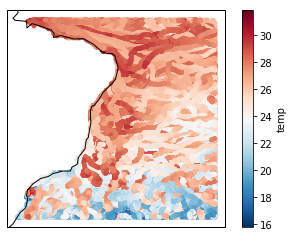

In [21]:
ne_brasil = (df.lon>-60) & (df.lon<-20) & (df.lat>-30) & (df.lat<0)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
df.loc[ne_brasil].plot(kind='scatter', x='lon', y='lat', c='temp', cmap='RdBu_r', edgecolor='none', ax=ax)

In [22]:
np.unique(df.loc[ne_brasil]['id']).size

1333

In [23]:
np.min(df.loc[ne_brasil].date)

Timestamp('1993-02-22 06:00:00')

In [24]:
np.max(df.loc[ne_brasil].date)

Timestamp('2019-04-01 06:00:00')

In [9]:
# how much data is still available if we restrict thte time interval
zone = (df.lon>0) & (df.lon<160) & (df.lat>-60) & (df.lat<30)
zone_time = (df.lon>0) & (df.lon<160) & (df.lat>-60) & (df.lat<30) & (df.date>'2014-03-08')
print('%d datapoints instead of %d for the complete data range (%2.1f%%).' % (np.sum(zone_time), np.sum(zone), np.sum(zone_time)/np.sum(zone)*100))

2509818 datapoints instead of 8731508 for the complete data range (28.7%).


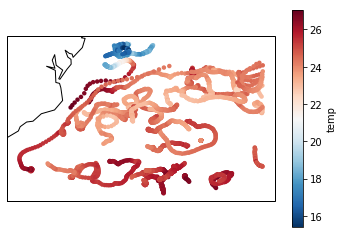

In [20]:
# plot a specific drifters
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
zone = (df.lon>-85) & (df.lon<-60) & (df.lat>28) & (df.lat<40) & (df.date>'2017-11-1') & (df.date<'2017-12-01')
df.loc[zone].plot(kind='scatter', x='lon', y='lat', c='temp', cmap='RdBu_r', edgecolor='none', ax=ax)

In [47]:
dfid.head()

,month,day,year,lat,lon,temp,ve,vn,spd,var_lat,var_lon,var_tmp,date,datenum,ldate,drogue
id,,,,,,,,,,,,,,,,
7702986.0,3.0,8.00,1988.0,-1.320,-85.152,25.473,NaN,NaN,NaN,0.000025,0.000034,0.004518,1988-03-08 00:00:00,726170.00,1988-08-26,True
7702986.0,3.0,8.25,1988.0,-1.242,-85.228,25.224,-49.214,36.778,61.438,0.000058,0.000087,0.007215,1988-03-08 06:00:00,726170.25,1988-08-26,True
7702986.0,3.0,8.50,1988.0,-1.176,-85.343,25.095,-57.514,28.439,64.161,0.000020,0.000026,0.005613,1988-03-08 12:00:00,726170.50,1988-08-26,True
7702986.0,3.0,8.75,1988.0,-1.131,-85.452,25.545,-48.625,28.747,56.487,0.000049,0.000072,0.005837,1988-03-08 18:00:00,726170.75,1988-08-26,True
7702986.0,3.0,9.00,1988.0,-1.064,-85.532,25.870,-50.787,34.399,61.340,0.000004,0.000006,0.003111,1988-03-09 00:00:00,726171.00,1988-08-26,True


In [39]:
list_ids = np.unique(df.loc[zone].id)
print(list_ids)

[  116363.   116364.   122656.   139080.   141571. 60205090. 60448280.
 61516870. 61879850. 62322360. 62326350. 62329360. 63221590. 63221600.
 63221960. 63222600. 63225600. 63250690. 63251230. 63251240. 63510950.
 63515980. 63517600. 63940940. 63940960. 63942780. 63942820. 63942850.
 64017030. 64018110. 64500780. 64776940. 64779920. 64903870. 64909810.]


In [ ]:
for d_id in list_ids:
    fig = plt.figure(figsize=((20,12)))
    ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
    ax.set_title(d_id)
    ax.coastlines()
    xd = dfid.loc[d_id, 'lon']
    yd = dfid.loc[d_id, 'lat']
    
    time = dfid.loc[d_id, 'date']
    trange = (time>'2017-11-01') & (time<'2018-01-01')
    xd = xd[trange]
    yd = yd[trange]
    ax.plot(xd, yd)
    fig.show()

In [51]:
gulf_stream = [63222600, 64017030]
export_col = ['datenum', 'lon', 'lat', 'drogue']

for d_id in gulf_stream:
    dfid.loc[d_id].to_csv(folder + 'gdp-%s.csv' % d_id, columns = export_col)

In [25]:
dfid = df.set_index('id')
dfid.head()

,month,day,year,lat,lon,temp,ve,vn,spd,var_lat,var_lon,var_tmp,date,datenum,ldate,drogue
id,,,,,,,,,,,,,,,,
7702986.0,3.0,8.00,1988.0,-1.320,-85.152,25.473,NaN,NaN,NaN,0.000025,0.000034,0.004518,1988-03-08 00:00:00,726170.00,1988-08-26,True
7702986.0,3.0,8.25,1988.0,-1.242,-85.228,25.224,-49.214,36.778,61.438,0.000058,0.000087,0.007215,1988-03-08 06:00:00,726170.25,1988-08-26,True
7702986.0,3.0,8.50,1988.0,-1.176,-85.343,25.095,-57.514,28.439,64.161,0.000020,0.000026,0.005613,1988-03-08 12:00:00,726170.50,1988-08-26,True
7702986.0,3.0,8.75,1988.0,-1.131,-85.452,25.545,-48.625,28.747,56.487,0.000049,0.000072,0.005837,1988-03-08 18:00:00,726170.75,1988-08-26,True
7702986.0,3.0,9.00,1988.0,-1.064,-85.532,25.870,-50.787,34.399,61.340,0.000004,0.000006,0.003111,1988-03-09 00:00:00,726171.00,1988-08-26,True


In [229]:
count = 0
for drifter_id in np.unique(dfid.index):
    # when time is 100 days apart most-likely the drifters ID was reused
    gap = np.where(np.diff(dfid.loc[drifter_id, 'datenum'])>365)[0]
    if len(gap)>0:
        count += 1
        print('Drifters ID %d with gap at indices: ' % (drifter_id), end='')
        print(gap)
print(count)

Drifters ID 35945 with gap at indices: [1110]
Drifters ID 37634 with gap at indices: [1216]
Drifters ID 79096 with gap at indices: [307]
Drifters ID 92818 with gap at indices: [2041]
Drifters ID 118530 with gap at indices: [3970]
Drifters ID 122550 with gap at indices: [1372]
Drifters ID 9422249 with gap at indices: [927]
Drifters ID 9422255 with gap at indices: [899]
Drifters ID 10822640 with gap at indices: [1821]
Drifters ID 11023190 with gap at indices: [2284]
Drifters ID 11027150 with gap at indices: [3062]
Drifters ID 11547080 with gap at indices: [656]
Drifters ID 11548420 with gap at indices: [1384]
Drifters ID 11795230 with gap at indices: [1309]
Drifters ID 11846540 with gap at indices: [2153]
15


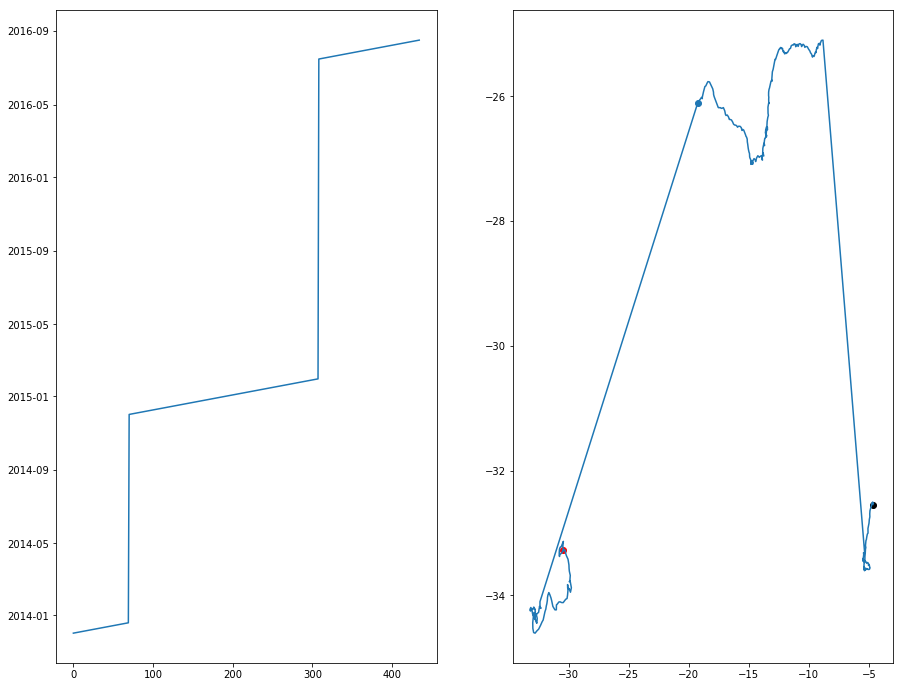

In [250]:
did = 79096
fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.plot(np.arange(0, len(dfid.loc[did, 'lon'])), dfid.loc[did, 'date'])
ax2.plot(dfid.loc[did, 'lon'], dfid.loc[did, 'lat'])


ax2.scatter(dfid.loc[did, 'lon'].iloc[0], dfid.loc[did, 'lat'].iloc[0], c='k')
ax2.scatter(dfid.loc[did, 'lon'].iloc[307], dfid.loc[did, 'lat'].iloc[307])
ax2.scatter(dfid.loc[did, 'lon'].iloc[-1], dfid.loc[did, 'lat'].iloc[-1], c='r')

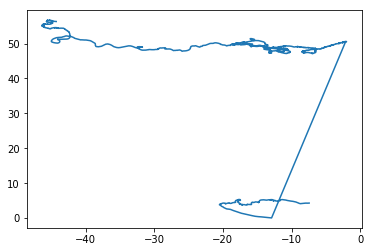

In [181]:
plt.plot(dfid.loc[11023190, 'lon'], dfid.loc[11023190, 'lat'])

CPU times: user 1min 17s, sys: 4.64 s, total: 1min 22s
Wall time: 1min 23s


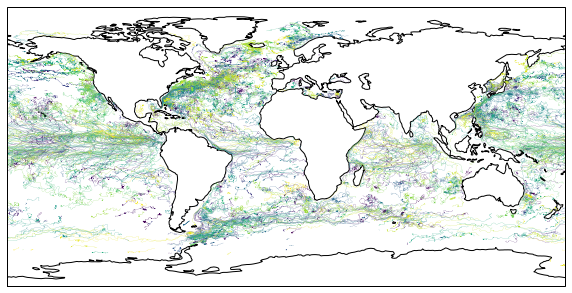

In [115]:
%%time

df_drogued = df[df['drogue']]
df_drogued_id = df_drogued.set_index('id')

fig, ax = plt.subplots(figsize=(18,12))
ax = plt.axes(projection = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines(color = 'black')

segs = []
for drifter_id in np.unique(df_drogued.id)[::10]:
    xd = df_drogued_id.loc[drifter_id, 'lon']
    yd = df_drogued_id.loc[drifter_id, 'lat']
    
    if type(xd) != np.float64: # only one value
        cross_world = np.where(np.diff(np.sign(xd)) != 0)[0]
        cross_world = np.unique(np.insert(cross_world, [0, len(cross_world)], [-1, len(xd) - 1]))
        for k in range(0, len(cross_world) - 1):
            ind = np.arange(cross_world[k] + 1, cross_world[k + 1] + 1)

            if len(ind) > 1:
                segs_i = list(zip(xd.iloc[ind], yd.iloc[ind]))
                segs.append(segs_i)

segments = LineCollection(segs, linewidths=0.15)
segments.set_array(np.arange(0,len(segs)))
ax.add_collection(segments)

In [167]:
df_undrogued = df[~df['drogue']]
df_undrogued_id = df_undrogued.set_index('id')

11023190.0


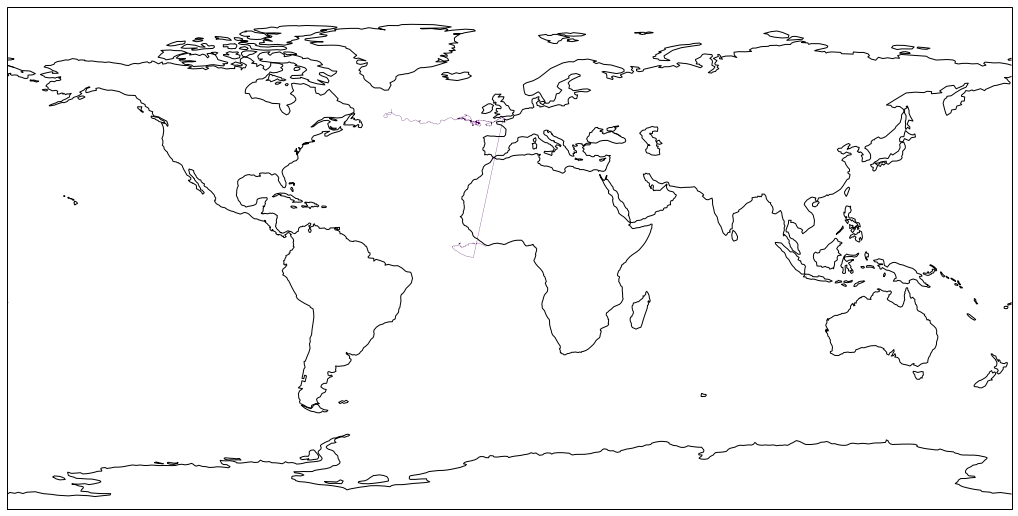

In [176]:
fig, ax = plt.subplots(figsize=(18,12))
ax = plt.axes(projection = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines(color = 'black')

segs = []
for drifter_id in [np.unique(df_undrogued.id)[12800]]:
    print(drifter_id)
    xd = df_undrogued_id.loc[drifter_id, 'lon']
    yd = df_undrogued_id.loc[drifter_id, 'lat']
    
    if type(xd) != np.float64: # only one value
        cross_world = np.where(np.diff(np.sign(xd)) != 0)[0]
        cross_world = np.unique(np.insert(cross_world, [0, len(cross_world)], [-1, len(xd) - 1]))
        for k in range(0, len(cross_world) - 1):
            ind = np.arange(cross_world[k] + 1, cross_world[k + 1] + 1)
            if len(ind) > 1:
                segs_i = list(zip(xd.iloc[ind], yd.iloc[ind]))
                segs.append(segs_i)

segments = LineCollection(segs, linewidths=0.25)
segments.set_array(np.arange(0, len(segs)))
ax.add_collection(segments)

In [ ]:
# get id of drifters passing through this box
min_lon, max_lon = 26.5, 27
min_lat, max_lat = -35.5, -34.5
zone = (df.lon>min_lon) & (df.lon<max_lon) & (df.lat>min_lat) & (df.lat<max_lat)
zone = np.logical_and(zone, df['drogue'])
alghulas_ids = np.unique(df.id[zone])

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax = plt.axes(projection = ccrs.PlateCarree())
ax.set_extent([5, 50, -50, -15], ccrs.PlateCarree())
ax.coastlines(resolution = '50m', color = 'black')
for drifter_id in alghulas_ids:
    lon = dfid.loc[drifter_id, 'lon'].values
    lat = dfid.loc[drifter_id, 'lat'].values
    ax.plot(lon, lat)

/Users/pmiron/miniconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


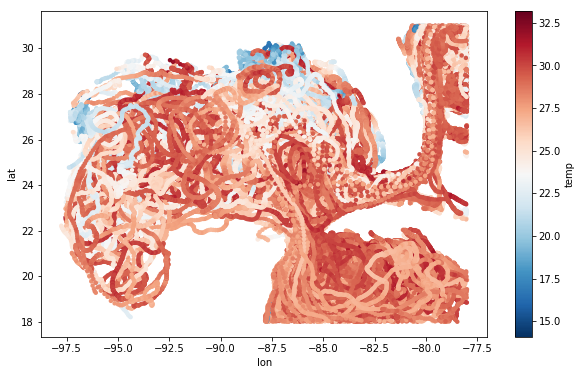

In [12]:
fig, ax = plt.subplots(figsize=(10,6))
zone = (df.lon>-98) & (df.lon<-78) & (df.lat>18) & (df.lat<31)
df.loc[zone].plot(kind='scatter', x='lon', y='lat', c='temp', cmap='RdBu_r', edgecolor='none', ax=ax)

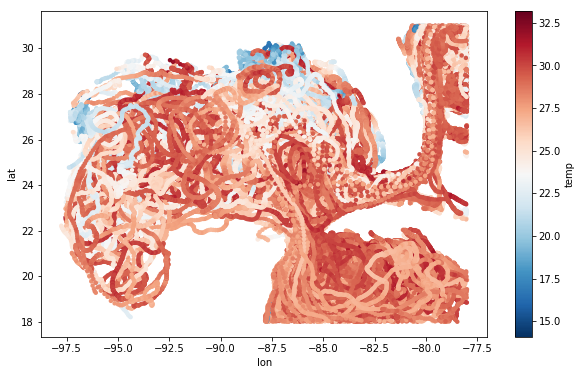

In [13]:
fig, ax = plt.subplots(figsize=(10,6))
zone = (df.lon>-98) & (df.lon<-78) & (df.lat>18) & (df.lat<31)
df.loc[zone].plot(kind='scatter', x='lon', y='lat', c='temp', 
         cmap='RdBu_r', edgecolor='none', ax=ax)

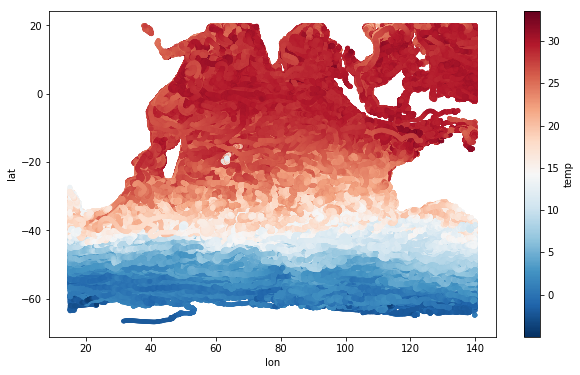

In [14]:
fig, ax = plt.subplots(figsize=(10,6))
zone = (df.lon>15) & (df.lon<140) & (df.lat>-90) & (df.lat<20)
df.loc[zone].plot(kind='scatter', x='lon', y='lat', c='temp', cmap='RdBu_r', edgecolor='none', ax=ax)

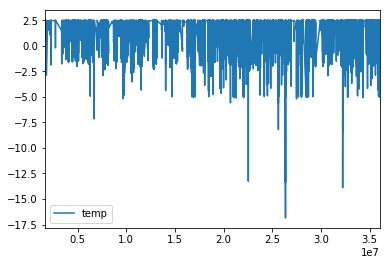

In [15]:
# plot temperature under 0
zone = df.temp < 2.5
df.loc[zone].plot(kind='line', y='temp')

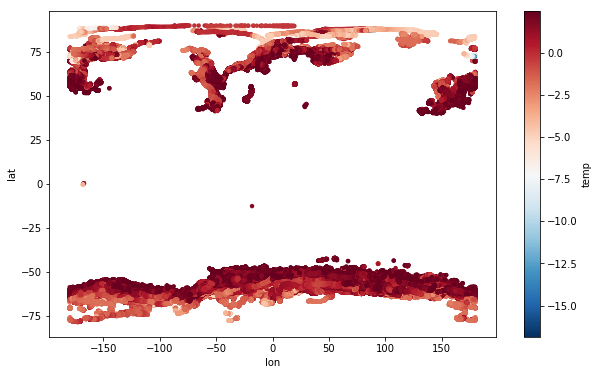

In [16]:
fig, ax = plt.subplots(figsize=(10,6))
zone = df.temp < 2.5
df.loc[zone].plot(kind='scatter', x='lon', y='lat', c='temp', cmap='RdBu_r', edgecolor='None', ax=ax)

In [ ]:
# I don't get how temperature < 0.... min value is ~-11C !
df.loc[zone].hist('temp', bins = 100)

In [ ]:
df.describe()